In [ ]:
# Step 1: Setting up the environment

# Install necessary libraries with specific versions
!pip install transformers datasets requests==2.31.0 pyarrow==14.0.1
!pip install nltk
!pip install tqdm
import nltk
nltk.download('wordnet')
import torch
import torch.nn as nn # Import torch.nn
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.cuda.amp import GradScaler, autocast
import random
from nltk.corpus import wordnet
import os
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

# Suppress specific warning
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers.optimization')
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='huggingface_hub.utils._token')



# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 36.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2


[nltk_data] Downloading package wordnet to /root/nltk_data...


Using device: cuda


**Load All Datasets**

In [2]:


# Load datasets
snips_dataset = load_dataset("snips_built_in_intents")  # Intent Recognition
multiwoz_dataset = load_dataset("multi_woz_v22")  # Dialogue State Tracking and Dialogue Act Recognition
conll_dataset = load_dataset("conll2012_ontonotesv5", "english_v4")  # Coreference Resolution - Specify the config

# Verify that datasets are loaded correctly
print(snips_dataset["train"][0])
print(multiwoz_dataset["train"][0])
print(conll_dataset["train"][0])

Generating train split:   0%|          | 0/328 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1940 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/222 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/222 [00:00<?, ? examples/s]

{'text': "Share my location with Hillary's sister", 'label': 5}
{'dialogue_id': 'PMUL4398.json', 'services': ['restaurant', 'hotel'], 'turns': {'turn_id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], 'utterance': ['i need a place to dine in the center thats expensive', 'I have several options for you; do you prefer African, Asian, or British food?', 'Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?', 'There is an Afrian place named Bedouin in the centre. How does that sound?', 'Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?', "Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town.", 'Yes. Can you book it for me?', 'Sure, when would you like that reservation?', 'i want to book it for 2 people and 2 nights starting from saturday.', 'Your booking wa

**Preprocess Snips NLU Benchmark,**
**Define Model Architecture,**
**Training and Evaluation**

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Epoch 1/20
----------


Training: 100%|██████████| 82/82 [00:05<00:00, 14.72it/s]


Train loss: 2.203186619572523 | Train accuracy: 0.19083969465648856 | Train precision: 0.16522488883764172 | Train recall: 0.19083969465648856 | Train F1: 0.17312596330971922


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.01it/s]


Validation loss: 1.8541839599609375 | Validation accuracy: 0.4090909090909091 | Validation precision: 0.18892045454545456 | Validation recall: 0.4090909090909091 | Validation F1: 0.2579124579124579
Epoch 2/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 24.21it/s]


Train loss: 1.7549317784425689 | Train accuracy: 0.4129770992366412 | Train precision: 0.4321991751679396 | Train recall: 0.4129770992366412 | Train F1: 0.33072830791622937


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.01it/s]


Validation loss: 1.3620803833007813 | Validation accuracy: 0.6060606060606061 | Validation precision: 0.5311519961519962 | Validation recall: 0.6060606060606061 | Validation F1: 0.5409760322861927
Epoch 3/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 24.27it/s]


Train loss: 1.3634812293983087 | Train accuracy: 0.5916030534351145 | Train precision: 0.628872552133531 | Train recall: 0.5916030534351145 | Train F1: 0.5497349016822757


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.52it/s]


Validation loss: 1.0389518737792969 | Validation accuracy: 0.803030303030303 | Validation precision: 0.8112554112554112 | Validation recall: 0.803030303030303 | Validation F1: 0.7878087611420944
Epoch 4/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 23.99it/s]


Train loss: 0.9841293474523033 | Train accuracy: 0.7641221374045801 | Train precision: 0.7905463319452576 | Train recall: 0.7641221374045801 | Train F1: 0.7508380005811254


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Validation loss: 0.6433258056640625 | Validation accuracy: 0.803030303030303 | Validation precision: 0.8107261956544254 | Validation recall: 0.803030303030303 | Validation F1: 0.7889289722623056
Epoch 5/20
----------


Training: 100%|██████████| 82/82 [00:06<00:00, 12.31it/s]


Train loss: 0.6650409051557866 | Train accuracy: 0.8732824427480916 | Train precision: 0.8788362643561572 | Train recall: 0.8732824427480916 | Train F1: 0.8706714748701474


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


Validation loss: 0.47361297607421876 | Validation accuracy: 0.8939393939393939 | Validation precision: 0.9105820105820105 | Validation recall: 0.8939393939393939 | Validation F1: 0.8872574955908288
Epoch 6/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 23.78it/s]


Train loss: 0.4100371602831817 | Train accuracy: 0.9389312977099237 | Train precision: 0.9406183647004768 | Train recall: 0.9389312977099237 | Train F1: 0.9380433701382158


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s]


Validation loss: 0.2988557815551758 | Validation accuracy: 0.9242424242424242 | Validation precision: 0.9324795574795575 | Validation recall: 0.9242424242424242 | Validation F1: 0.9201251330039208
Epoch 7/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 22.87it/s]


Train loss: 0.2580995201701071 | Train accuracy: 0.9725190839694656 | Train precision: 0.9734108063459858 | Train recall: 0.9725190839694656 | Train F1: 0.9724981856008371


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


Validation loss: 0.19567060470581055 | Validation accuracy: 0.9696969696969697 | Validation precision: 0.9716209716209716 | Validation recall: 0.9696969696969697 | Validation F1: 0.9690492223825556
Epoch 8/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 23.91it/s]


Train loss: 0.17591905675646735 | Train accuracy: 0.9854961832061069 | Train precision: 0.9856094560207213 | Train recall: 0.9854961832061069 | Train F1: 0.9854448088732142


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


Validation loss: 0.18686599731445314 | Validation accuracy: 0.9848484848484849 | Validation precision: 0.9859307359307359 | Validation recall: 0.9848484848484849 | Validation F1: 0.9848260381593715
Epoch 9/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 24.89it/s]


Train loss: 0.11935021655588615 | Train accuracy: 0.9969465648854962 | Train precision: 0.9969909944050752 | Train recall: 0.9969465648854962 | Train F1: 0.996942049792412


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Validation loss: 0.11944799423217774 | Validation accuracy: 0.9696969696969697 | Validation precision: 0.9716209716209716 | Validation recall: 0.9696969696969697 | Validation F1: 0.9690492223825556
Epoch 10/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 24.16it/s]


Train loss: 0.08343831213509165 | Train accuracy: 0.999236641221374 | Train precision: 0.9992445928753181 | Train recall: 0.999236641221374 | Train F1: 0.9992373188528556


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s]


Validation loss: 0.07603178024291993 | Validation accuracy: 0.9696969696969697 | Validation precision: 0.9716209716209716 | Validation recall: 0.9696969696969697 | Validation F1: 0.9690492223825556
Epoch 11/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 24.28it/s]


Train loss: 0.06303840752963613 | Train accuracy: 1.0 | Train precision: 1.0 | Train recall: 1.0 | Train F1: 1.0


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Validation loss: 0.07316899299621582 | Validation accuracy: 0.9848484848484849 | Validation precision: 0.9859307359307359 | Validation recall: 0.9848484848484849 | Validation F1: 0.9848260381593715
Epoch 12/20
----------


Training: 100%|██████████| 82/82 [00:03<00:00, 24.70it/s]


Train loss: 0.05227564479701403 | Train accuracy: 0.999236641221374 | Train precision: 0.9992432219005001 | Train recall: 0.999236641221374 | Train F1: 0.999237259151614


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


Validation loss: 0.0676121711730957 | Validation accuracy: 0.9696969696969697 | Validation precision: 0.9716209716209716 | Validation recall: 0.9696969696969697 | Validation F1: 0.9690492223825556
Early stopping


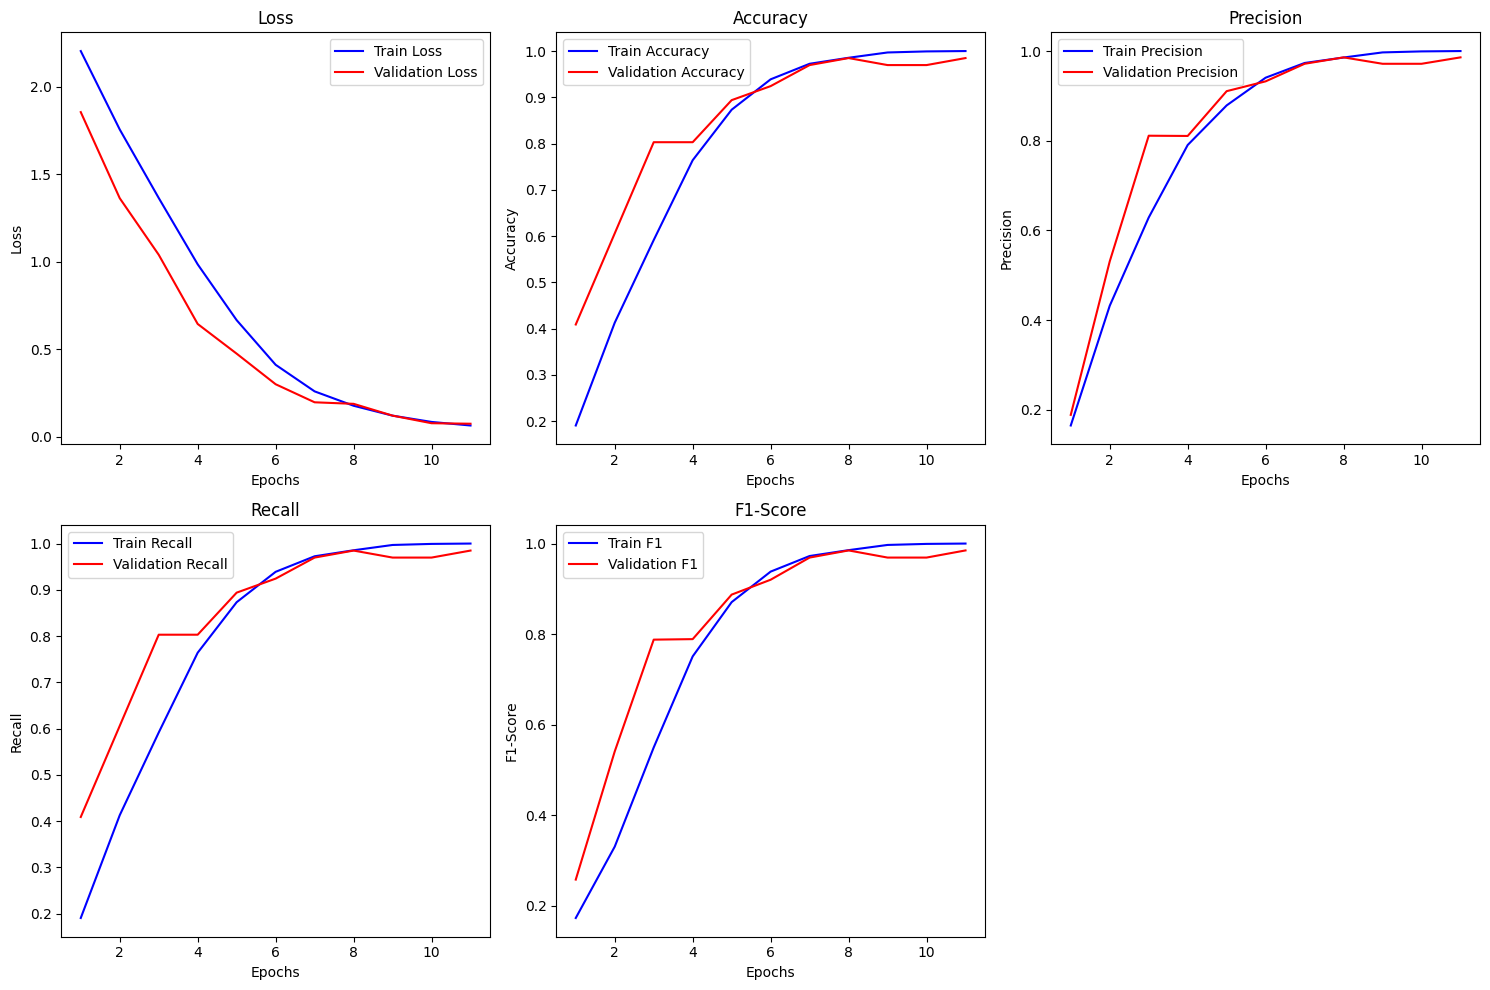

Evaluating: 100%|██████████| 3/3 [00:00<00:00, 10.83it/s]

Test loss: 0.05639195442199707
Test accuracy: 0.9696969696969697
Test precision: 0.9734848484848485
Test recall: 0.9696969696969697
Test F1: 0.9698158051099226


Text: What's the weather like in 3 days?
Prediction: 2
Label: 2

Text: Book a table for 3 people at a restaurant that serve tapas and wine for tonight
Prediction: 7
Label: 7

Text: Need a table for lunch to eat steak near penn station
Prediction: 7
Label: 7

Text: Share my location to mum until I get to school
Prediction: 5
Label: 5

Text: Who is playing tonight at the Madison Square Garden?
Prediction: 4
Label: 4

Model checkpoint saved to snips_checkpoint.pth


In [ ]:
import warnings

# Suppress the specific UserWarning
warnings.filterwarnings("ignore", category=UserWarning, message=".*To copy construct from a tensor.*")

# Split the train dataset into train and validation sets
train_dataset = snips_dataset["train"]
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)

# Create custom datasets for training and validation
train_split = train_dataset.select(train_indices)
val_split = train_dataset.select(val_indices)

class SnipsDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset[index]
        input_text = data["text"]  # Ensure the key is correct
        label = data["label"]  # Ensure the key is correct

        inputs = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long),  # Direct conversion
            "text": input_text  # Include the 'text' field
        }

def custom_collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    texts = [item['text'] for item in batch]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels,
        'text': texts
    }

# Create DataLoaders with pin_memory and multiple workers
def create_data_loader(dataset, tokenizer, batch_size=16):
    ds = SnipsDataset(dataset, tokenizer)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, collate_fn=custom_collate_fn)

snips_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_data_loader = create_data_loader(train_split, snips_tokenizer)
val_data_loader = create_data_loader(val_split, snips_tokenizer)

# Define the Seq2Seq Model with Dropout
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, encoder_tokenizer, decoder_tokenizer, num_labels, dropout_rate=0.5):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.dropout = nn.Dropout(p=dropout_rate)  # Increased dropout rate to 50%
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        encoder_hidden_states = encoder_outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token's hidden state

        encoder_hidden_states = self.dropout(encoder_hidden_states)  # Apply dropout

        logits = self.classifier(encoder_hidden_states)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return logits if loss is None else {"loss": loss, "logits": logits}

# Load pre-trained models
bert_encoder = BertModel.from_pretrained("bert-base-uncased")

# Initialize GPT-2 with cross-attention layers enabled
gpt_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
gpt_decoder = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt_config)

# Initialize the tokenizers
encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
decoder_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Number of unique labels in the dataset
num_labels = len(snips_dataset["train"].unique("label"))

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_encoder.to(device)
gpt_decoder.to(device)

# Initialize the Seq2Seq model
seq2seq_model = Seq2SeqModel(bert_encoder, gpt_decoder, encoder_tokenizer, decoder_tokenizer, num_labels).to(device)

# Define the optimizer with weight decay
optimizer = AdamW(seq2seq_model.parameters(), lr=1e-5, weight_decay=0.01)  # Added weight decay

# Initialize the gradient scaler for mixed precision training
scaler = GradScaler()

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Adding tqdm for progress bar and number of samples
from tqdm import tqdm

# Define the training function with gradient accumulation
def train_epoch(model, data_loader, optimizer, device, scaler, accumulation_steps=4):
    model.train()

    losses = []
    all_preds = []
    all_labels = []

    optimizer.zero_grad()

    for i, d in enumerate(tqdm(data_loader, desc="Training", total=len(data_loader))):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)  # Use 'label' instead of 'labels'

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"] / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        preds = torch.argmax(outputs["logits"], dim=-1)
        all_preds.extend(preds.detach().cpu().numpy().flatten())
        all_labels.extend(labels.detach().cpu().numpy().flatten())
        losses.append(loss.item() * accumulation_steps)

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return accuracy, avg_loss, precision, recall, f1

# Define the evaluation function
def eval_model(model, data_loader, device):
    model.eval()

    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating", total=len(data_loader)):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"]

            preds = torch.argmax(outputs["logits"], dim=-1)
            all_preds.extend(preds.detach().cpu().numpy().flatten())
            all_labels.extend(labels.detach().cpu().numpy().flatten())
            losses.append(loss.item())

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return accuracy, avg_loss, precision, recall, f1

# Augment the dataset with synonym replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def augment_dataset(dataset, num_augmentations=4):
    augmented_data = []
    for example in dataset:
        text = example["text"]
        label = example["label"]
        augmented_data.append({"text": text, "label": label})
        for _ in range(num_augmentations):
            augmented_text = synonym_replacement(text, n=2)
            augmented_data.append({"text": augmented_text, "label": label})
    return augmented_data

# Augment the train dataset
augmented_train_data = augment_dataset(train_split)

# Create custom SnipsDataset with augmented data
augmented_train_split = SnipsDataset(augmented_train_data, snips_tokenizer)

# Re-create DataLoader with augmented data
train_data_loader = create_data_loader(augmented_train_split, snips_tokenizer)

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

# Training and evaluation loop for the snips dataset
EPOCHS = 20

# Initialize early stopping
early_stopping = EarlyStopping(patience=2, min_delta=0.01)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss, train_precision, train_recall, train_f1 = train_epoch(seq2seq_model, train_data_loader, optimizer, device, scaler)
    print(f"Train loss: {train_loss} | Train accuracy: {train_acc} | Train precision: {train_precision} | Train recall: {train_recall} | Train F1: {train_f1}")

    val_acc, val_loss, val_precision, val_recall, val_f1 = eval_model(seq2seq_model, val_data_loader, device)
    print(f"Validation loss: {val_loss} | Validation accuracy: {val_acc} | Validation precision: {val_precision} | Validation recall: {val_recall} | Validation F1: {val_f1}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_precisions, 'b', label='Train Precision')
plt.plot(epochs, val_precisions, 'r', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_recalls, 'b', label='Train Recall')
plt.plot(epochs, val_recalls, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1s, 'b', label='Train F1')
plt.plot(epochs, val_f1s, 'r', label='Validation F1')
plt.title('F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate model on test data

# Split the validation set into validation and test sets
val_indices, test_indices = train_test_split(list(range(len(val_split))), test_size=0.5, random_state=42)

# Create custom datasets for validation and test
val_split_new = val_split.select(val_indices)
test_split = val_split.select(test_indices)

# Create DataLoaders for the new validation and test sets
val_data_loader_new = create_data_loader(val_split_new, snips_tokenizer)
test_data_loader = create_data_loader(test_split, snips_tokenizer)

# Evaluate the model on the test set
test_acc, test_loss, test_precision, test_recall, test_f1 = eval_model(seq2seq_model, test_data_loader, device)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1: {test_f1}")

def review_predictions(model, data_loader, device):
    model.eval()

    all_preds = []
    all_labels = []
    all_texts = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            texts = d["text"]  # Extract the 'text' field

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                preds = torch.argmax(outputs["logits"], dim=-1)

            all_preds.extend(preds.detach().cpu().numpy().flatten())
            all_labels.extend(labels.detach().cpu().numpy().flatten())
            all_texts.extend(texts)

    return all_texts, all_preds, all_labels

texts, preds, labels = review_predictions(seq2seq_model, test_data_loader, device)

for i in range(5):
    print(f"Text: {texts[i]}")
    print(f"Prediction: {preds[i]}")
    print(f"Label: {labels[i]}")
    print()

# Save the model state dictionary
torch.save(seq2seq_model.state_dict(), "snips_checkpoint.pth")
print("Model checkpoint saved to snips_checkpoint.pth")



**Preprocess MultiWOZ Dataset, Define Model Architecture, Training and Evaluation**

Processing dialogue acts...
Dialogue acts processed.
Number of unique dialogue acts: 36
Creating data loader...
Starting to prepare data...


Preparing data:   7%|▋         | 2000/26948 [00:02<00:32, 775.20it/s]


Data preparation completed.
Dataset length: 26648
Data loader created.
Creating data loader...
Starting to prepare data...


Preparing data:   7%|▋         | 1000/14748 [00:01<00:19, 717.53it/s]


Data preparation completed.
Dataset length: 14594
Data loader created.
Loading pre-trained models...


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

BERT and GPT-2 initialized successfully.
Seq2SeqModel initialized successfully.
Using device: cuda
BERT encoder moved to device successfully.
GPT-2 decoder moved to device successfully.
Seq2SeqModel moved to device successfully.
Loading checkpoint...
Checkpoint loaded.
Model checkpoint loaded and set to evaluation mode.
Model moved to cuda.
Epoch 1/20
----------


Training: 100%|██████████| 833/833 [00:32<00:00, 25.59it/s]


Train loss: 1.7529 | Train accuracy: 0.5720 | Train precision: 0.5285 | Train recall: 0.5720 | Train F1: 0.5343


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 20.99it/s]


Validation loss: 0.8166 | Validation accuracy: 0.7903 | Validation precision: 0.7652 | Validation recall: 0.7903 | Validation F1: 0.7616
Epoch time: 54.41 seconds
Epoch 2/20
----------


Training: 100%|██████████| 833/833 [00:32<00:00, 25.78it/s]


Train loss: 0.8142 | Train accuracy: 0.7939 | Train precision: 0.7611 | Train recall: 0.7939 | Train F1: 0.7695


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 21.02it/s]


Validation loss: 0.5916 | Validation accuracy: 0.8320 | Validation precision: 0.8108 | Validation recall: 0.8320 | Validation F1: 0.8146
Epoch time: 54.13 seconds
Epoch 3/20
----------


Training: 100%|██████████| 833/833 [00:32<00:00, 25.40it/s]


Train loss: 0.6076 | Train accuracy: 0.8358 | Train precision: 0.8173 | Train recall: 0.8358 | Train F1: 0.8192


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 20.97it/s]


Validation loss: 0.5081 | Validation accuracy: 0.8507 | Validation precision: 0.8392 | Validation recall: 0.8507 | Validation F1: 0.8400
Epoch time: 54.66 seconds
Epoch 4/20
----------


Training: 100%|██████████| 833/833 [00:32<00:00, 25.73it/s]


Train loss: 0.5068 | Train accuracy: 0.8578 | Train precision: 0.8428 | Train recall: 0.8578 | Train F1: 0.8456


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 21.07it/s]


Validation loss: 0.4907 | Validation accuracy: 0.8551 | Validation precision: 0.8477 | Validation recall: 0.8551 | Validation F1: 0.8480
Epoch time: 54.14 seconds
Epoch 5/20
----------


Training: 100%|██████████| 833/833 [00:31<00:00, 26.16it/s]


Train loss: 0.4440 | Train accuracy: 0.8736 | Train precision: 0.8638 | Train recall: 0.8736 | Train F1: 0.8638


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 21.12it/s]


Validation loss: 0.4756 | Validation accuracy: 0.8588 | Validation precision: 0.8500 | Validation recall: 0.8588 | Validation F1: 0.8519
Epoch time: 53.57 seconds
Epoch 6/20
----------


Training: 100%|██████████| 833/833 [00:32<00:00, 25.83it/s]


Train loss: 0.3914 | Train accuracy: 0.8851 | Train precision: 0.8771 | Train recall: 0.8851 | Train F1: 0.8768


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 21.11it/s]


Validation loss: 0.4903 | Validation accuracy: 0.8567 | Validation precision: 0.8482 | Validation recall: 0.8567 | Validation F1: 0.8488
Epoch time: 53.98 seconds
Epoch 7/20
----------


Training: 100%|██████████| 833/833 [00:32<00:00, 25.70it/s]


Train loss: 0.3489 | Train accuracy: 0.8985 | Train precision: 0.8935 | Train recall: 0.8985 | Train F1: 0.8915


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 21.05it/s]


Validation loss: 0.4796 | Validation accuracy: 0.8577 | Validation precision: 0.8541 | Validation recall: 0.8577 | Validation F1: 0.8513
Epoch time: 54.21 seconds
Early stopping


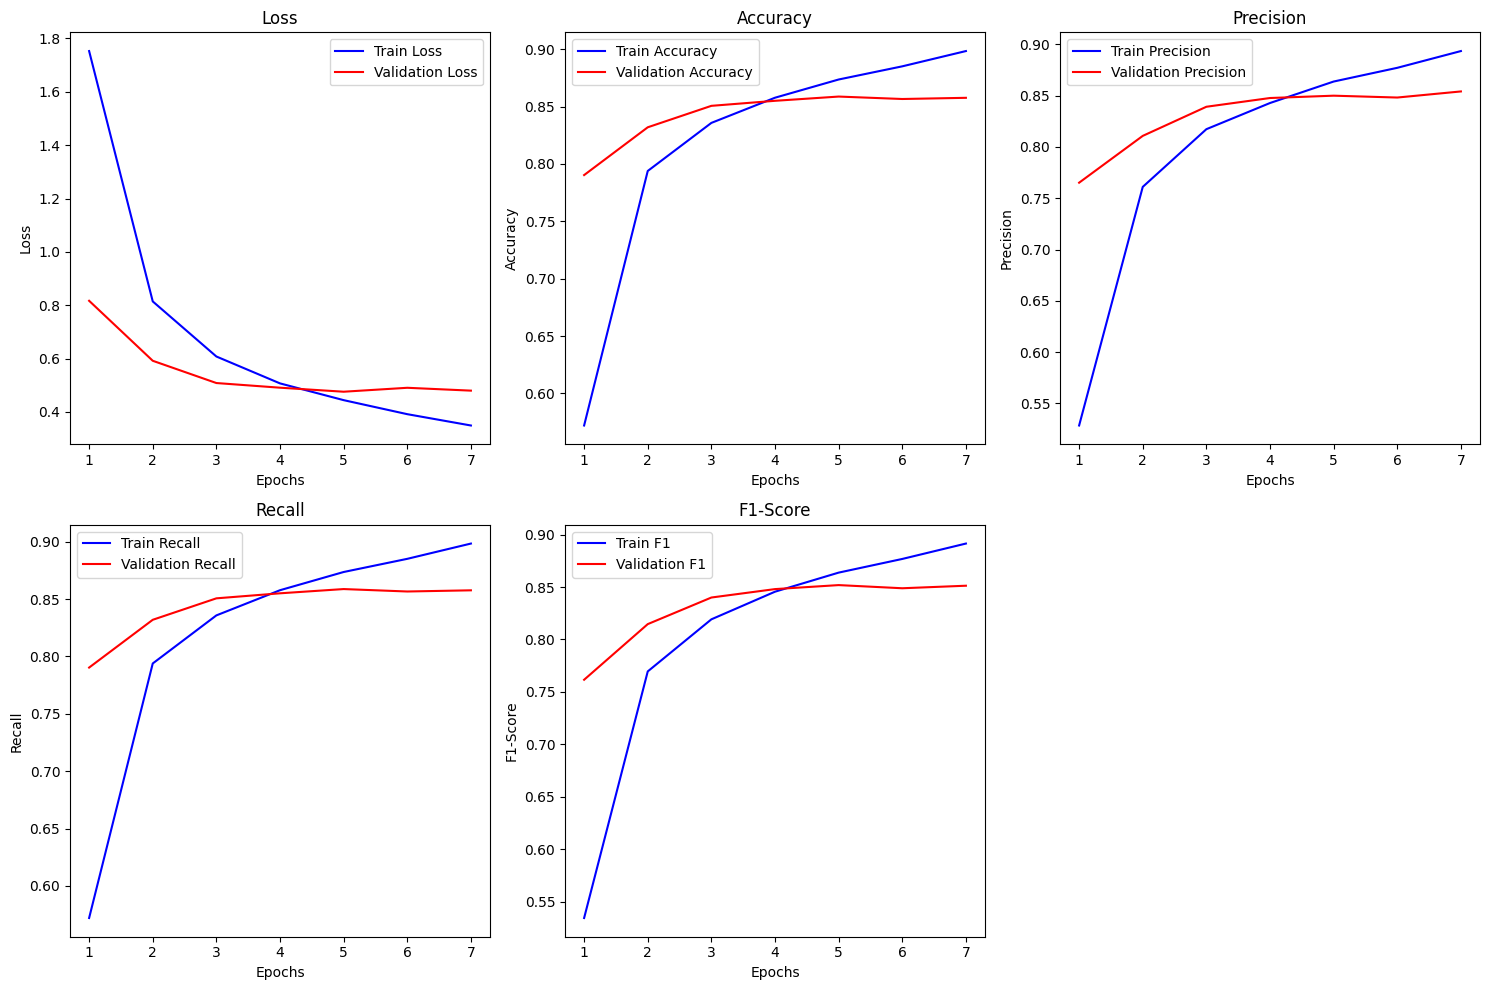

Creating data loader...
Starting to prepare data...


Preparing data:   7%|▋         | 1000/14744 [00:01<00:18, 743.42it/s]


Data preparation completed.
Dataset length: 14613
Data loader created.
Evaluating the model on the test set...


Evaluating: 100%|██████████| 457/457 [00:21<00:00, 21.03it/s]


Test loss: 0.4865 | Test accuracy: 0.8556 | Test precision: 0.8519 | Test recall: 0.8556 | Test F1: 0.8492
Model checkpoint saved at snips_multiwoz_checkpoint_final.pth


In [ ]:
# Set CUDA_LAUNCH_BLOCKING to help with debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss >= self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class MultiWOZDataset(Dataset):
    def __init__(self, dataset, tokenizer, act2idx, max_len=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.act2idx = act2idx
        self.max_len = max_len
        self.data = self._prepare_data()

    def _prepare_data(self):
        data = []
        print("Starting to prepare data...")
        total_turns = sum(len(dialogue["turns"]["utterance"]) for dialogue in self.dataset)
        for dialogue in tqdm(self.dataset, total=total_turns, desc="Preparing data"):
            for turn_id, utterance in enumerate(dialogue["turns"]["utterance"]):
                dialogue_acts = []
                if "dialogue_acts" in dialogue["turns"]:
                    turn_dialogue_acts = dialogue["turns"]["dialogue_acts"][turn_id]["dialog_act"]
                    for act_type in turn_dialogue_acts["act_type"]:
                        dialogue_acts.append(act_type)

                if dialogue_acts:
                    label = self.act2idx.get(dialogue_acts[0], -1)
                else:
                    label = -1

                if label != -1:
                    data.append({"utterance": utterance, "label": label})
        print("Data preparation completed.")
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        input_text = data["utterance"]
        label = data["label"]

        inputs = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(dataset, tokenizer, act2idx, batch_size=32):
    print("Creating data loader...")
    ds = MultiWOZDataset(dataset, tokenizer, act2idx)
    print(f"Dataset length: {len(ds)}")
    data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
    print("Data loader created.")
    return data_loader

# multiwoz_dataset is already loaded
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

all_dialogue_acts = set()
print("Processing dialogue acts...")
for dialogue in multiwoz_dataset["train"]:
    for turn in dialogue["turns"]["dialogue_acts"]:
        for act in turn["dialog_act"]["act_type"]:
            all_dialogue_acts.add(act)
print("Dialogue acts processed.")

act2idx = {act: idx for idx, act in enumerate(all_dialogue_acts)}
print(f"Number of unique dialogue acts: {len(act2idx)}")

# Reduce dataset size for quick testing
train_data_loader = create_data_loader(Subset(multiwoz_dataset["train"], range(2000)), bert_tokenizer, act2idx, batch_size=32)
val_data_loader = create_data_loader(Subset(multiwoz_dataset["validation"], range(1000)), bert_tokenizer, act2idx, batch_size=32)

class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, encoder_tokenizer, decoder_tokenizer, num_labels):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.dropout = nn.Dropout(p=0.5)  # Reduced dropout rate
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        encoder_hidden_states = encoder_outputs.last_hidden_state[:, 0, :]
        encoder_hidden_states = self.dropout(encoder_hidden_states)
        logits = self.classifier(encoder_hidden_states)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return logits if loss is None else {"loss": loss, "logits": logits}

# Initialize and load BERT and GPT-2 separately
print("Loading pre-trained models...")
try:
    bert_encoder = BertModel.from_pretrained("bert-base-uncased")
    gpt_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
    gpt_decoder = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt_config)
    print("BERT and GPT-2 initialized successfully.")

    # Initialize Seq2SeqModel without moving to device
    seq2seq_model = Seq2SeqModel(bert_encoder, gpt_decoder, bert_tokenizer, gpt2_tokenizer, len(act2idx))
    print("Seq2SeqModel initialized successfully.")

    # Move encoder to device and test
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    bert_encoder.to(device)
    print("BERT encoder moved to device successfully.")

    # Move decoder to device and test
    gpt_decoder.to(device)
    print("GPT-2 decoder moved to device successfully.")

    # Move entire Seq2SeqModel to device
    seq2seq_model.to(device)
    print("Seq2SeqModel moved to device successfully.")
except RuntimeError as e:
    print(f"Error during model initialization or moving to device: {e}")
    raise e

checkpoint_path = "snips_checkpoint.pth"
print("Loading checkpoint...")
checkpoint = torch.load(checkpoint_path, map_location=device)
seq2seq_model.encoder.load_state_dict({k: v for k, v in checkpoint.items() if k.startswith('encoder.')}, strict=False)
seq2seq_model.decoder.load_state_dict({k: v for k, v in checkpoint.items() if k.startswith('decoder.')}, strict=False)
print("Checkpoint loaded.")

seq2seq_model.eval()
print("Model checkpoint loaded and set to evaluation mode.")
print(f"Model moved to {device}.")

def train_epoch(model, data_loader, optimizer, device, scaler, accumulation_steps=4):
    model.train()
    losses = []
    all_labels = []
    all_preds = []
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(data_loader, desc="Training")):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"] / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        preds = torch.argmax(outputs["logits"], dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        losses.append(loss.item() * accumulation_steps)

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return accuracy, avg_loss, precision, recall, f1

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(data_loader, desc="Evaluating")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]

            preds = torch.argmax(outputs["logits"], dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            losses.append(loss.item())

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return accuracy, avg_loss, precision, recall, f1

EPOCHS = 20
early_stopping = EarlyStopping(patience=2, min_delta=0.01)
optimizer = AdamW(seq2seq_model.parameters(), lr=1e-5)
scaler = GradScaler()

# Metric lists
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss, train_precision, train_recall, train_f1 = train_epoch(seq2seq_model, train_data_loader, optimizer, device, scaler)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Train precision: {train_precision:.4f} | Train recall: {train_recall:.4f} | Train F1: {train_f1:.4f}")

    val_acc, val_loss, val_precision, val_recall, val_f1 = eval_model(seq2seq_model, val_data_loader, device)
    print(f"Validation loss: {val_loss:.4f} | Validation accuracy: {val_acc:.4f} | Validation precision: {val_precision:.4f} | Validation recall: {val_recall:.4f} | Validation F1: {val_f1:.4f}")

    epoch_time = time.time() - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds")

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_precisions, 'b', label='Train Precision')
plt.plot(epochs, val_precisions, 'r', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_recalls, 'b', label='Train Recall')
plt.plot(epochs, val_recalls, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1s, 'b', label='Train F1')
plt.plot(epochs, val_f1s, 'r', label='Validation F1')
plt.title('F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation for test data

# Create the test data loader
test_data_loader = create_data_loader(multiwoz_dataset["test"], bert_tokenizer, act2idx, batch_size=32)

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_acc, test_loss, test_precision, test_recall, test_f1 = eval_model(seq2seq_model, test_data_loader, device)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f} | Test precision: {test_precision:.4f} | Test recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")


# Save the model checkpoint
def save_checkpoint(model, path="model_checkpoint.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model checkpoint saved at {path}")

# Call this function after training
save_checkpoint(seq2seq_model, "snips_multiwoz_checkpoint_final.pth")


**Preprocess CoNLL-2012 Dataset, Define Model Architecture, Training and Evaluation**

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Using device: cuda
Model successfully moved to device
Model checkpoint loaded from snips_multiwoz_checkpoint_final.pth
Checkpoint loaded successfully


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Using device: cuda
Model successfully moved to device
Model checkpoint loaded from snips_multiwoz_checkpoint_final.pth
Checkpoint loaded successfully
Epoch 1/10
----------


Training: 100%|██████████| 1175/1175 [01:04<00:00, 18.13it/s]


Train loss: 0.3593 | Train accuracy: 0.8528 | Train precision: 0.8470 | Train recall: 0.8528 | Train F1: 0.8412


Evaluating: 100%|██████████| 151/151 [00:02<00:00, 55.60it/s]


Validation loss: 0.3363 | Validation accuracy: 0.8641 | Validation precision: 0.8657 | Validation recall: 0.8641 | Validation F1: 0.8534
Epoch time: 67.65 seconds
Epoch 2/10
----------


Training: 100%|██████████| 1175/1175 [01:05<00:00, 18.07it/s]


Train loss: 0.3057 | Train accuracy: 0.8787 | Train precision: 0.8751 | Train recall: 0.8787 | Train F1: 0.8724


Evaluating: 100%|██████████| 151/151 [00:02<00:00, 55.66it/s]


Validation loss: 0.3248 | Validation accuracy: 0.8685 | Validation precision: 0.8652 | Validation recall: 0.8685 | Validation F1: 0.8627
Epoch time: 67.84 seconds
Epoch 3/10
----------


Training: 100%|██████████| 1175/1175 [01:05<00:00, 18.06it/s]


Train loss: 0.2767 | Train accuracy: 0.8910 | Train precision: 0.8883 | Train recall: 0.8910 | Train F1: 0.8861


Evaluating: 100%|██████████| 151/151 [00:02<00:00, 56.30it/s]


Validation loss: 0.3409 | Validation accuracy: 0.8672 | Validation precision: 0.8687 | Validation recall: 0.8672 | Validation F1: 0.8572
Epoch time: 67.84 seconds
Epoch 4/10
----------


Training: 100%|██████████| 1175/1175 [01:04<00:00, 18.08it/s]


Train loss: 0.2463 | Train accuracy: 0.9062 | Train precision: 0.9045 | Train recall: 0.9062 | Train F1: 0.9027


Evaluating: 100%|██████████| 151/151 [00:02<00:00, 56.14it/s]


Validation loss: 0.3485 | Validation accuracy: 0.8702 | Validation precision: 0.8684 | Validation recall: 0.8702 | Validation F1: 0.8630
Epoch time: 67.80 seconds
Epoch 5/10
----------


Training: 100%|██████████| 1175/1175 [01:05<00:00, 18.06it/s]


Train loss: 0.2097 | Train accuracy: 0.9220 | Train precision: 0.9209 | Train recall: 0.9220 | Train F1: 0.9197


Evaluating: 100%|██████████| 151/151 [00:02<00:00, 54.97it/s]


Validation loss: 0.3950 | Validation accuracy: 0.8614 | Validation precision: 0.8583 | Validation recall: 0.8614 | Validation F1: 0.8593
Epoch time: 67.92 seconds
Early stopping triggered.


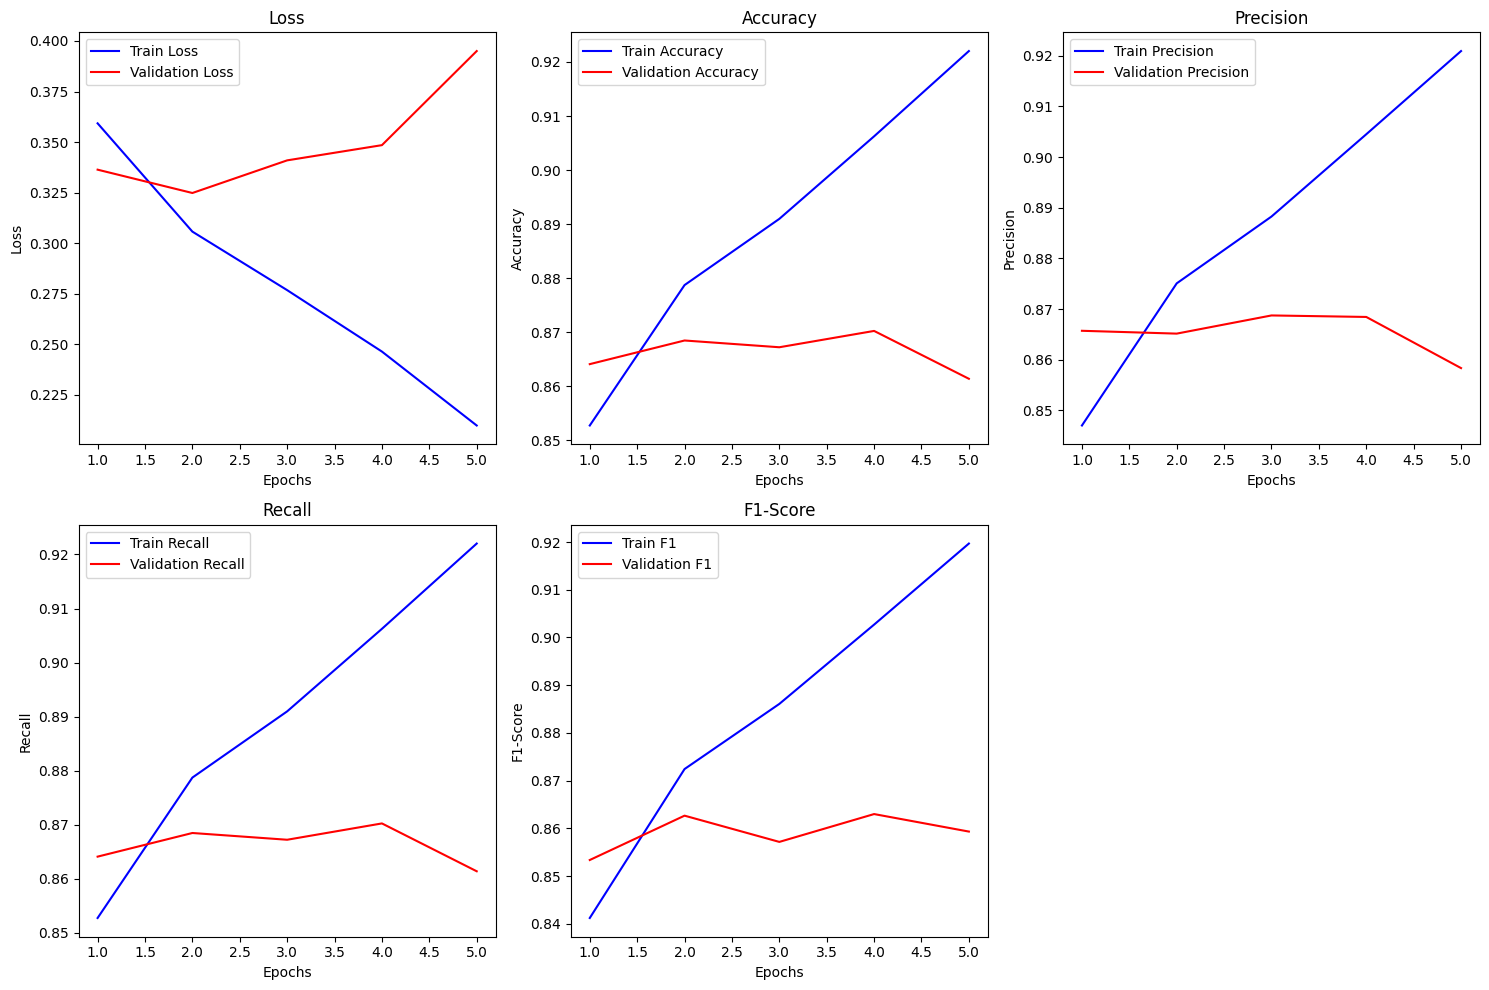

Model checkpoint saved at snips_multiwoz_conll2012_finetuned_checkpoint_final.pth
Starting test evaluation...


Testing: 100%|██████████| 149/149 [00:02<00:00, 55.11it/s]

Test loss: 0.3693 | Test accuracy: 0.8650 | Test precision: 0.8631 | Test recall: 0.8650 | Test F1: 0.8639


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss >= self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# CoNLL Dataset class
class CoNLLDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = self._prepare_data()

    def _prepare_data(self):
        data = []
        for item in self.dataset:
            for sentence_info in item['sentences']:
                words = sentence_info['words']
                coref_spans = sentence_info['coref_spans']
                input_text = " ".join(words)
                inputs = self.tokenizer(
                    input_text,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors="pt"
                )
                input_ids = inputs["input_ids"].squeeze()
                attention_mask = inputs["attention_mask"].squeeze()
                if coref_spans:
                    label = min(coref_spans[0][0], 1)  # Binary classification (0 or 1)
                else:
                    label = 0  # No coreference
                data.append({
                    "input_ids": input_ids,
                    "attention_mask": attention_mask,
                    "label": torch.tensor(label, dtype=torch.long)
                })
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Create DataLoader
def create_data_loader(dataset, tokenizer, batch_size=16, num_workers=4):
    ds = CoNLLDataset(dataset, tokenizer)
    data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
    return data_loader

# Define Seq2Seq Model
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, encoder_tokenizer, decoder_tokenizer, num_labels):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        encoder_hidden_states = encoder_outputs.last_hidden_state[:, 0, :]
        encoder_hidden_states = self.dropout(encoder_hidden_states)
        logits = self.classifier(encoder_hidden_states)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return logits if loss is None else {"loss": loss, "logits": logits}

# Load pre-trained models
bert_encoder = BertModel.from_pretrained("bert-base-uncased")
gpt_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
gpt_decoder = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt_config)
encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
decoder_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
num_labels = 2  # Binary classification (0 or 1)
try:
    seq2seq_model = Seq2SeqModel(bert_encoder, gpt_decoder, encoder_tokenizer, decoder_tokenizer, num_labels).to(device)
    print("Model successfully moved to device")
except Exception as e:
    print(f"Error moving model to device: {e}")

# Load the model checkpoint
def load_checkpoint(model, path):
    checkpoint = torch.load(path, map_location=device)
    # Load all state_dict except for classifier
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k not in ['classifier.weight', 'classifier.bias']}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    model.eval()  # Set the model to evaluation mode
    print(f"Model checkpoint loaded from {path}")

# Save the model checkpoint
def save_checkpoint(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model checkpoint saved at {path}")

# Load the last checkpoint
try:
    load_checkpoint(seq2seq_model, "snips_multiwoz_checkpoint_final.pth")
    print("Checkpoint loaded successfully")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

scaler = torch.cuda.amp.GradScaler()

# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=2):
    model.train()
    losses = []
    all_labels = []
    all_preds = []
    optimizer.zero_grad()

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"] / accumulation_steps

        scaler.scale(loss).backward()

        if (len(losses) + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()  # Update the scheduler here

        preds = torch.argmax(outputs["logits"], dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        losses.append(loss.item() * accumulation_steps)

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return accuracy, avg_loss, precision, recall, f1

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"]

            preds = torch.argmax(outputs["logits"], dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            losses.append(loss.item())

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return accuracy, avg_loss, precision, recall, f1

# Training on new dataset
def train_on_new_dataset(model, train_data_loader, val_data_loader, epochs=10):
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

    # Scheduler
    total_steps = len(train_data_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_checkpoint_path = "snips_multiwoz_conll2012_finetuned_checkpoint_final.pth"

    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1s = []

    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        start_time = time.time()
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 10)

        train_acc, train_loss, train_precision, train_recall, train_f1 = train_epoch(model, train_data_loader, optimizer, scheduler, device)
        print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Train precision: {train_precision:.4f} | Train recall: {train_recall:.4f} | Train F1: {train_f1:.4f}")

        val_acc, val_loss, val_precision, val_recall, val_f1 = eval_model(model, val_data_loader, device)
        print(f"Validation loss: {val_loss:.4f} | Validation accuracy: {val_acc:.4f} | Validation precision: {val_precision:.4f} | Validation recall: {val_recall:.4f} | Validation F1: {val_f1:.4f}")

        epoch_time = time.time() - start_time
        print(f"Epoch time: {epoch_time:.2f} seconds")

        # Append metrics to lists
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Plotting
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, train_losses, 'b', label='Train Loss')
    plt.plot(epochs_range, val_losses, 'r', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, train_accuracies, 'b', label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, train_precisions, 'b', label='Train Precision')
    plt.plot(epochs_range, val_precisions, 'r', label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, train_recalls, 'b', label='Train Recall')
    plt.plot(epochs_range, val_recalls, 'r', label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, train_f1s, 'b', label='Train F1')
    plt.plot(epochs_range, val_f1s, 'r', label='Validation F1')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save the final checkpoint after training
    save_checkpoint(model, best_checkpoint_path)

# Function to evaluate the model on the test set
def evaluate_on_test_set(model, data_loader, device):
    model.eval()
    losses = []
    all_labels = []
    all_preds = []

    print("Starting test evaluation...")
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"]

            preds = torch.argmax(outputs["logits"], dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            losses.append(loss.item())

    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    print(f"Test loss: {avg_loss:.4f} | Test accuracy: {accuracy:.4f} | Test precision: {precision:.4f} | Test recall: {recall:.4f} | Test F1: {f1:.4f}")

# Load and Prepare the Dataset
conll_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create subsets of the dataset for quick testing
train_subset = Subset(conll_dataset['train'], range(2000))
val_subset = Subset(conll_dataset['validation'], range(1000))

train_data_loader = create_data_loader(train_subset, conll_tokenizer, batch_size=64)
val_data_loader = create_data_loader(val_subset, conll_tokenizer, batch_size=64)

# Initialize the Model
bert_encoder = BertModel.from_pretrained("bert-base-uncased")
gpt_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
gpt_decoder = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt_config)
encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
decoder_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_labels = 2  # Binary classification (0 or 1)
try:
    seq2seq_model = Seq2SeqModel(bert_encoder, gpt_decoder, encoder_tokenizer, decoder_tokenizer, num_labels).to(device)
    print("Model successfully moved to device")
except Exception as e:
    print(f"Error moving model to device: {e}")

# Load Model Checkpoint
try:
    load_checkpoint(seq2seq_model, "snips_multiwoz_checkpoint_final.pth")
    print("Checkpoint loaded successfully")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

# Train the Model
train_on_new_dataset(seq2seq_model, train_data_loader, val_data_loader, epochs=10)

# Evaluate on the Test Set
test_subset = Subset(conll_dataset['test'], range(1000))
test_data_loader = create_data_loader(test_subset, conll_tokenizer, batch_size=64)
evaluate_on_test_set(seq2seq_model, test_data_loader, device)


**Download the model checkpoint to local machine**

In [ ]:
from google.colab import files
files.download("snips_multiwoz_conll2012_finetuned_checkpoint_final.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>